<a href="https://colab.research.google.com/github/doeungim/ADP_DE/blob/main/ADP_31_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import scipy.stats as stats


In [2]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_1_obesity_v2.csv',encoding= 'cp949')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262 entries, 0 to 1261
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      1262 non-null   int64  
 1   id                              1262 non-null   object 
 2   Gender                          1262 non-null   object 
 3   Age                             1262 non-null   int64  
 4   Height                          1262 non-null   float64
 5   Weight                          1262 non-null   int64  
 6   family_history_with_overweight  1262 non-null   object 
 7   FAVC                            1262 non-null   object 
 8   FCVC                            1262 non-null   object 
 9   NCP                             1262 non-null   int64  
 10  CAEC                            1262 non-null   object 
 11  SMOKE                           1262 non-null   object 
 12  CH2O                            12

In [3]:
df2 = df.drop(columns = ['Unnamed: 0', 'id'], axis = 1).reset_index(drop= True)


In [4]:
df2.NCP = df2.NCP.astype('object')

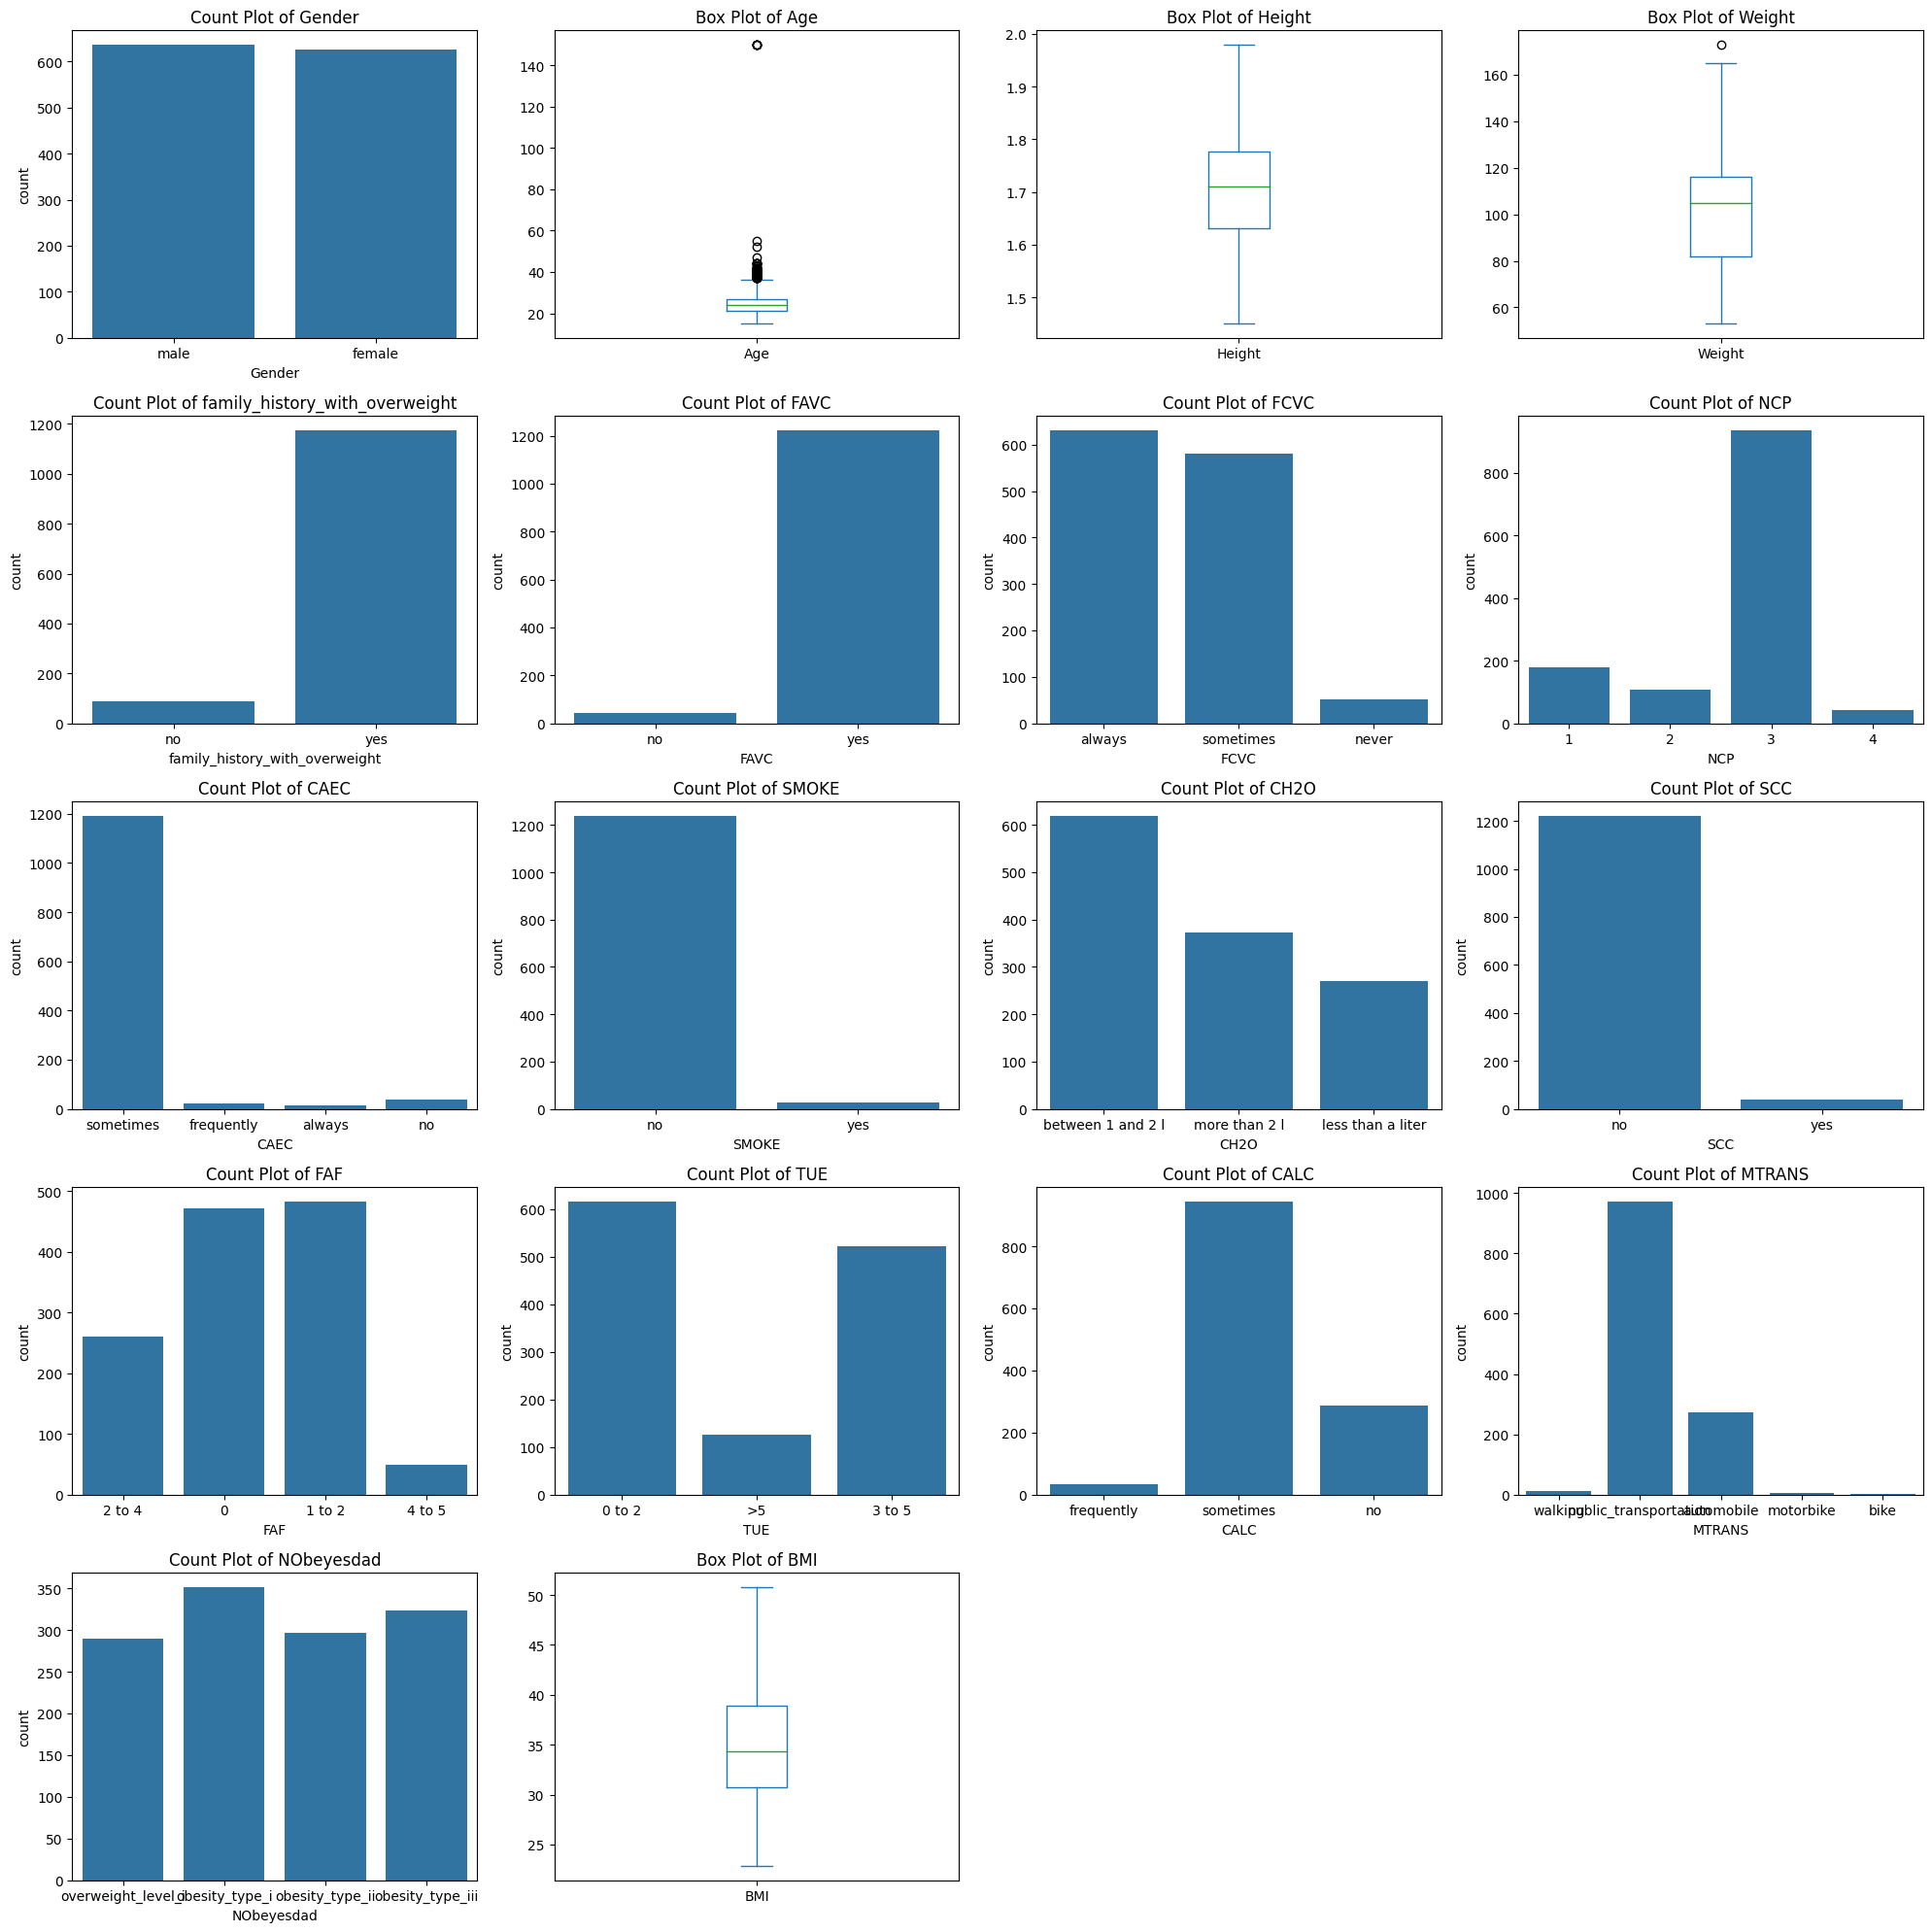

In [5]:
# EDA

fig, axes = plt.subplots(5,4, figsize = (20,20))
axes = axes.flatten()

counter = 0
for col in df2.columns:
  if df2[col].dtypes == 'object' :
    sns.countplot(ax = axes[counter], x = df2[col])
    axes[counter].set_title(f"Count Plot of {col}")
    counter += 1

  elif df2[col].dtypes == 'int64' or df2[col].dtypes =='float64' :
    df2[col].plot(kind = 'box' , ax = axes[counter])
    axes[counter].set_title(f"Box Plot of {col}")
    counter +=1

for i in range(counter, len(axes)) :
  axes[i].set_visible(False)

plt.tight_layout()
plt.show()



In [6]:
# 이상치 제거
df2 = df2.loc[df2['Age'] <= 100]


In [7]:
## 파생변수
df3 = df2.copy()
# 1) CALC - 이진 - 종종,  때때로 1: year 0: No로 치환
df3['CALC'] =  df3['CALC'].map(lambda x : 1 if x in ['frequently', 'sometimes'] else 0).astype('object')

# 2) Age- Binning
bins = [0,20,30,40,50,100]
labels = ['0-20', '20-30', '30-40', '40-50', '50+']
df3['Age_Group'] = pd.cut(df3['Age'], bins = bins, labels = labels , right = False).astype('object')


# 3) BMI - 체중 수준
df3['bmi_level'] = pd.cut(df3['BMI'] , bins = [0 , 20 , 25, float('inf')], labels = ['저제충', '정상','과체중']).astype('object')

In [8]:
## Encoder

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

la = LabelEncoder()
ss = StandardScaler()

for col in df3.select_dtypes(include = 'object').columns :
  df3[col] = la.fit_transform(df3[col])


num_col = ['Age', 'Height','Weight', 'BMI']

num_df = df3[num_col]
cat_df = df3.drop(columns = [col for col in df3.columns if col  in num_col])

In [9]:
ss_num_df = pd.DataFrame(ss.fit_transform(num_df), columns = num_df.columns)
print(ss_num_df.shape)
print(cat_df.shape)

(1257, 4)
(1257, 16)


In [10]:
cat_df = pd.DataFrame(cat_df)
df_ready = pd.concat([ss_num_df, cat_df], axis = 1).dropna()

In [11]:
y = df_ready['NObeyesdad']
X = df_ready.drop('NObeyesdad', axis = 1)

## 앙상블을 제외한 분류모델 3가지
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Model
lr = LogisticRegression()
dt = DecisionTreeClassifier()
lgbm = LGBMClassifier(verbose = -1)


lr.fit(x_train, y_train)
dt.fit(x_train, y_train)
lgbm.fit(x_train, y_train)

lr_pred = lr.predict(x_test)
dt_pred = dt.predict(x_test)
lg_pred = lgbm.predict(x_test)


lr_score = accuracy_score(y_test, lr_pred)
dt_score = accuracy_score(y_test, dt_pred)
lg_score = accuracy_score(y_test, lg_pred)

print(lr_score, dt_score, lg_score)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.973404255319149 0.9840425531914894 0.9840425531914894


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score

params = {'max_depth': [10,30,50], 'num_leaves':[20,40,60]}

# precision
grid_lg = GridSearchCV(lgbm, param_grid = params, scoring = 'precision_weighted', cv = 5)
grid_lg.fit(x_train, y_train)
# best 파라미터 튜닝 결과
grid_lg_precision = grid_lg.best_estimator_

pred_lgbm = grid_lg.predict(x_test)
precision = precision_score(y_test, pred_lgbm, average = 'weighted')
recall = recall_score(y_test, pred_lgbm, average = 'weighted')

print(precision)
print(recall)

0.98514306676449
0.9840425531914894


In [13]:
## Modelling

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

model  = {
        'LR' : LogisticRegression(),
        'SVM' : SVC(),
        'KNN' : KNeighborsClassifier()
        }

for name, model in model.items():
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  print(f"{name} : Accuracy - {accuracy_score(y_test, y_pred)}")
  print(f"{name} : Precision - {precision_score(y_test, y_pred, average = 'macro')}")
  print(f"{name} : Recall - {recall_score(y_test, y_pred, average = 'macro')}")
  print(f"{name} : F1-score - {f1_score(y_test, y_pred, average = 'macro')}\n")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR : Accuracy - 0.973404255319149
LR : Precision - 0.972527435249419
LR : Recall - 0.9742268041237113
LR : F1-score - 0.9723000679423359

SVM : Accuracy - 0.9893617021276596
SVM : Precision - 0.9887349799732977
SVM : Recall - 0.9896907216494846
SVM : F1-score - 0.9890176786396209

KNN : Accuracy - 0.9468085106382979
KNN : Precision - 0.9444079556297859
KNN : Recall - 0.9465060926008931
KNN : F1-score - 0.9444102061969755



In [14]:
svc = SVC()
# SVC 객체의 매개변수 확인
params = svc.get_params()

# 매개변수 출력
for param, value in params.items():
    print(f"{param}: {value}")

C: 1.0
break_ties: False
cache_size: 200
class_weight: None
coef0: 0.0
decision_function_shape: ovr
degree: 3
gamma: scale
kernel: rbf
max_iter: -1
probability: False
random_state: None
shrinking: True
tol: 0.001
verbose: False


In [15]:
import warnings
warnings.filterwarnings("ignore")

knn = KNeighborsClassifier()
param_grid = {
    "n_neighbors" : [3, 5, 7, 9],
    "metric" : ['eculidean', 'manhattan', 'minkowski'],
    "leaf_size" : [10, 20, 40, 50],
    "n_jobs" : [1, 2, 5, 10],
}
grid_search = GridSearchCV(knn, param_grid, cv = 5, scoring='accuracy')

grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
y_pred_knn = best_model.predict(x_test)

print(f"Best_model: {best_model.n_neighbors}, {best_model.metric}, {best_model.leaf_size}, {best_model.n_jobs}")
print(f"Precision: {precision_score(y_test, y_pred_knn, average='macro')}")
print(f"Recall: {recall_score(y_test, y_pred_knn, average='macro')}")

Best_model: 3, manhattan, 10, 1
Precision: 0.9693707125271888
Recall: 0.9708602409371869


In [16]:
## Soft Voting
from sklearn.ensemble import VotingClassifier

soft_voting = VotingClassifier(estimators = [('lr', lr), ('dt', dt), ('lgb', lgbm)], voting = 'soft')
soft_voting.fit(x_train , y_train)
soft_pred = soft_voting.predict(x_test)

s_precision = precision_score(y_test, soft_pred, average = 'weighted')
s_recall = recall_score(y_test, soft_pred, average = 'weighted')

print(s_precision, s_recall)

0.9923062310030396 0.9920212765957447


<Axes: >

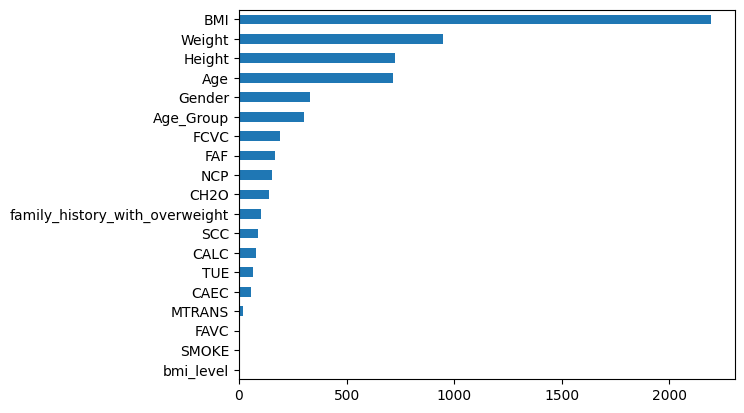

In [17]:
importance = pd.Series(grid_lg_precision.feature_importances_, x_train.columns)
importance.sort_values().plot.barh()

In [18]:
dataurl = "https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_2_v2.csv"
df = pd.read_csv(dataurl)
display(df.head(4))
display(df.dtypes)

,ID,키,weight,생년월일,건강검진일,공학여부,채소섭취정도,아침식사여부,일주일운동시간,수면시간,성별
0,ID_4135,169.01,65.47,20041003,2020_11_15,1,2,1,4.4,8.3,남성
1,ID_3289,181.62,69.36,19970725,2014_11_20,0,3,0,4.4,6.9,남성
2,ID_1847,160.89,65.12,20020921,2020_01_28,1,1,1,1.7,9.6,여성
3,ID_4785,162.21,62.28,20020106,2018_09_27,1,4,0,5.1,6.8,남성


ID          object
키          float64
weight     float64
생년월일         int64
건강검진일       object
공학여부         int64
채소섭취정도       int64
아침식사여부       int64
일주일운동시간    float64
수면시간       float64
성별          object
dtype: object

In [19]:
## BMI 계산
df['BMI'] = df['weight'] / (df['키'] / 100) ** 2

# 생년월일
df['생년월일']= pd.to_datetime(df['생년월일'].astype(str))

# 건강검진일
df['건강검진일'] = pd.to_datetime(df['건강검진일'].str.replace('_',''))



In [20]:
df['차이']= df['건강검진일'] - df['생년월일']
df['만나이']= df['차이']//365
df['만나이'] = df['만나이'].astype(str).str.split(' ').str[0] + '세'

In [38]:
#적정 체중 여부 (BMI가 아래 구간에 들어올 경우)
#17세 남자 : 21.03이상 23.21 미만
#17세 여자 : 20.03이상 22.39 미만
#16세 남자 : 21.18이상 23.45 미만
#16세 여자 : 19.61이상 21.74 미만


bmi_map = {
    ('17세', "남성") : (21.03 , 23.21) ,
    ('17세', "여성") : (20.03, 22.38) ,
    ('16세', "남성") : (21.18, 23.45) ,
    ('16세', "여성") : (19.61, 21.74 )
}

def check_bmi(age, gender, bmi) :
  lower, upper = bmi_map[(age, gender)]
  return lower <= bmi < upper

df['적정체중여부'] = [check_bmi(df['만나이'][i], df['성별'][i], df['BMI'][i]) for i in range(len(df))]
df['적정체중여부'] =  df['적정체중여부'].map(lambda x :'Y'  if x == True else 'N')
df['적정체중여부']

0       Y
1       N
2       N
3       N
4       Y
       ..
6796    N
6797    N
6798    Y
6799    N
6800    Y
Name: 적정체중여부, Length: 6801, dtype: object

 구한 적정 체중 여부와 나머지 컬럼(공학여부, 아침식사여부, 일주일운동시간, 채소섭취정도, 수면시간, 성별) 이 독립적인지 통계적으로 확인

In [ ]:
## ['공학여부','아침식사여부','성별', '채소섭취정도'] = 0,1 로 구성
# 일주일운동시간, 수면시간 - 로지스틱 회귀를 통한 p_value 검정

In [73]:
import statsmodels.api as sm

cat_col = ['공학여부','아침식사여부','성별', '채소섭취정도']
num_col = ['일주일운동시간', '수면시간']
cols = ['공학여부', '채소섭취정도', '아침식사여부', '성별', '일주일운동시간', '수면시간']

lst = []
for col in cols :
  if col in cat_col :
    cross_df = pd.crosstab(df[col], df['적정체중여부'])
    chi2, p_val, dof , exp = stats.chi2_contingency(cross_df)
    #print(f"{col} : {p_val}")
    lst.append([col,p_val])

  else :
    model = sm.OLS.from_formula(f"{col} ~ C(적정체중여부)", data = df)
    result = model.fit()
    #print(f"{col} : {result.pvalues[1]}")
    lst.append([col,result.pvalues[1]])


valid_df = pd.DataFrame(lst, columns = ['col_names', 'p_val'])
valid_df['check'] = valid_df['p_val'].map(lambda x : '유효' if x < 0.05 else '유효하지 않음')
valid_df

,col_names,p_val,check
0,공학여부,0.033035,유효
1,채소섭취정도,0.040383,유효
2,아침식사여부,0.695853,유효하지 않음
3,성별,0.892792,유효하지 않음
4,일주일운동시간,0.511156,유효하지 않음
5,수면시간,0.009020,유효


4-2에서 유의한 변수들만 가지고 적정 체중 여부를 예측하는 모델을 구현하고 성능 평가 및 해석

LR의 0.6036256736893679
xgb의 0.5663890249877511


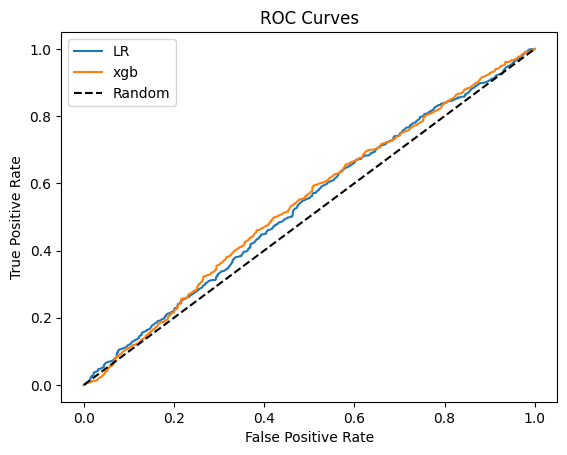

In [131]:
df1 = df.copy()
selected_col = list(valid_df[valid_df['check']== '유효']['col_names'].values)

import xgboost as xgb
from sklearn.metrics import roc_curve

X = df1[selected_col]
y = df1['적정체중여부'].map(lambda x : 1 if x == 'Y' else 0)
y

# train_test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234)

# Model
models = {
        'LR' : LogisticRegression(),
        'xgb' : xgb.XGBClassifier()
        }

for name, model in models.items() :
  model.fit(x_train, y_train)
  ## Predict
  pred = model.predict(x_test)
  ##Accuracy_Score
  accu = accuracy_score(y_test, pred)
  ## ROC_Curve를 위한 predict_proba
  prob = model.predict_proba(x_test)[:,1]

  fpr, tpr, thresholds = roc_curve(y_test, prob)
  plt.plot(fpr, tpr , label = name)

  print(f"{name}의 {accu}")

plt.plot([0,1],[0,1], 'k--', label = 'Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()
